#VGG 16

In this section, we inplement VGG 16 model to do the same classification problem. After training, we also use the model extracts feature from the skectch and realimage dataset to check the Top-k feature similarity.

How to run the code?

you can (1) only load the dataset to retrain the model from start or (2) load the dataset and pretrain model ,set RESUME = True to directly use the model.

In [ ]:
#@title 1.Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler


import random
import pandas as pd

from torchvision import transforms, utils


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

import sys,os
import fnmatch
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/CS5242')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#sys.path[0]

'/content/drive/My Drive/Colab Notebooks/CS5242'

In [ ]:
#@title 2.Build custom dataset
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

class ImageDataset(Dataset):
    """ Own dataset """

    def __init__(self, img_dir, fruit_category, image_size = 255, class_size = 5000,transform = False):
        """
        Args:
            sketch_dir (string): Directory to all the sketch images.
            realworld_dir (string): Directory to all the real world images.
            fruit_category: list to fruit catogory
            class_size: Num of images in each category
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.fruit_category = fruit_category
        self.class_size = class_size
        self.data_dict = dict(np.load(img_dir))
        self.image_size = image_size
       

        
        self.transform_img = transforms.Compose([transforms.ToPILImage(),
                                                transforms.Resize(image_size),
                                                transforms.ToTensor(),])
                                              # transforms.Normalize( mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
        self.transform_label = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return self.class_size * len(self.fruit_category)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        class_index = int(idx // self.class_size)
        category =  self.fruit_category[class_index]
        category_idx = int(idx % self.class_size)
        
        label = np.zeros((len(self.fruit_category), 1))
        label[class_index] = 1

#         print(class_index)
#         label = class_index
        
        image_ary =  self.data_dict[category][category_idx]
        
        sample = {'image': image_ary, 'label': label}
        if self.transform:
            sample['image'] = self.transform_img(sample['image'])
            sample['label'] = self.transform_label(sample['label'])
        return sample
  

In [ ]:
#@title 3.Build VGG16 model structure
class VGG16(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*2*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
      
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        out = self.fc1(out)
        out = self.fc2(out)
        return out

# sketch model 

In [ ]:
#@title  4.1 Quickdraw dataset preparing
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  
train_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_train.npz'
train_quickdraw = ImageDataset(train_quickdraw_dir, QURIES, image_size = 64, class_size = 4000,transform = True)
train_loader = DataLoader(train_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)

In [ ]:
test_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_test.npz'
test_quickdraw = ImageDataset(test_quickdraw_dir, QURIES, image_size = 64, class_size = 1000,transform = True)
test_loader = DataLoader(test_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)

In [ ]:
#@title 4.2 VGG16 hyper-parameter setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7
num_epochs = 15
batch_size = 128
learning_rate = 0.01  #0.03

model = VGG16(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.007, momentum = 0.9)  

# if use pretrained /retrieve model, please set RESUME = True
RESUME = False



In [ ]:
# record history data
if RESUME:
  checkpoint = torch.load(sys.path[0]+'/vgg16_model_quickdraw_10epoch_with_loss_lr_001.pth')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  train_quickdraw_acc = checkpoint['train_quickdraw_acc']
  train_quickdraw_loss = checkpoint["train_quickdraw_loss"]
  val_quickdraw_acc = checkpoint["val_quickdraw_acc"]
  val_quickdraw_loss= checkpoint["val_quickdraw_loss"]
  
else:
  start_epoch =0
  train_quickdraw_acc = []
  train_quickdraw_loss = []
  val_quickdraw_acc = []
  val_quickdraw_loss= []


In [ ]:
#@title 4.3 VGG16 sketch model training
import gc
total_step = len(train_loader)

for epoch in range(start_epoch,start_epoch+num_epochs):
    for data in train_loader:  
        # Move tensors to the configured device
        images = data['image'].to(device)
        labels = data['label'].to(device)
        correct_t = 0
        total_t = 0
        # Forward pass
        model.train()
        outputs = model(images)
        loss = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
        _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
        total_t += labels.size(0)
        correct_t +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    
    
    train_quickdraw_loss.append(loss.item())
    train_quickdraw_acc.append(correct_t/total_t)
    print ('Epoch [{}/{}], Training Loss: {:.4f}' 
                   .format(epoch+1,start_epoch+num_epochs, loss.item()))
            
    # Validation
    
    with torch.no_grad():
        model.eval()
        correct_v = 0
        total_v = 0
        for data in test_loader:
            images = data['image'].to(device)
            labels = data['label'].to(device)
        

            outputs = model(images)
            loss_v = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
   
            _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
            total_v += labels.size(0)
            correct_v +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()

            del images, labels, outputs
        val_quickdraw_loss.append(loss_v.item())
        val_quickdraw_acc.append(correct_v/total_v)
        print(f"Validation accuracy: {(correct_v/total_v):.3f}")
       
print(f"train_acc:{(np.mean([v for v in train_quickdraw_acc])):.3f},val_acc:{(np.mean([v for v in val_quickdraw_acc])):.3f}")

Epoch [1/15], Training Loss: 0.2607
Validation accuracy: 0.335
Epoch [2/15], Training Loss: 0.1048
Validation accuracy: 0.410
Epoch [3/15], Training Loss: 0.0771
Validation accuracy: 0.741
Epoch [4/15], Training Loss: 0.1852
Validation accuracy: 0.394
Epoch [5/15], Training Loss: 0.2120
Validation accuracy: 0.485
Epoch [6/15], Training Loss: 0.1961
Validation accuracy: 0.486
Epoch [7/15], Training Loss: 0.1071
Validation accuracy: 0.826
Epoch [8/15], Training Loss: 0.1743
Validation accuracy: 0.905
Epoch [9/15], Training Loss: 0.1485
Validation accuracy: 0.822
Epoch [10/15], Training Loss: 0.1720
Validation accuracy: 0.910
Epoch [11/15], Training Loss: 0.1444
Validation accuracy: 0.794
Epoch [12/15], Training Loss: 0.2152
Validation accuracy: 0.896
Epoch [13/15], Training Loss: 0.1815
Validation accuracy: 0.909
Epoch [14/15], Training Loss: 0.4037
Validation accuracy: 0.763
Epoch [15/15], Training Loss: 0.1925
Validation accuracy: 0.930
train_acc:0.941,val_acc:0.707


Save VGG16 model 

In [ ]:
torch.save({
            'epoch': 15,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_quickdraw_acc': train_quickdraw_acc,
            'train_quickdraw_loss': train_quickdraw_loss,
            'val_quickdraw_acc': val_quickdraw_acc,
            'val_quickdraw_loss': val_quickdraw_loss,
            
            }, sys.path[0]+'/best_vgg16_model_quickdraw_15epoch_with_loss_lr_001.pth')

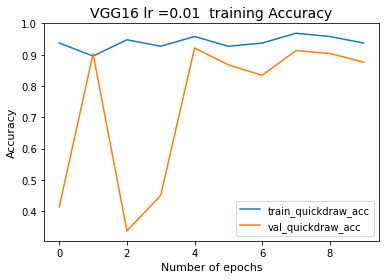

In [ ]:
#@title 4.4 Visulize model performance
import matplotlib.pyplot as plt
# Plot curve
x = [i for i in range(10)]
plt.plot(x, train_quickdraw_acc)
plt.plot(x, val_quickdraw_acc)

plt.legend(['train_quickdraw_acc', 'val_quickdraw_acc'], loc='lower right')
plt.title('VGG16 lr =0.01  training Accuracy',  fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)

plt.show()

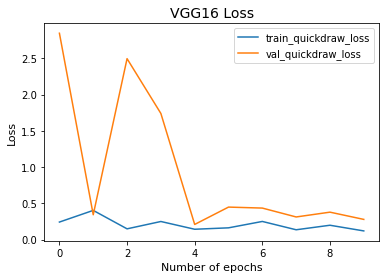

In [ ]:

# Plot curve
x = [i for i in range(10)]
plt.plot(x, train_quickdraw_loss)
plt.plot(x, val_quickdraw_loss)
plt.legend(['train_quickdraw_loss', 'val_quickdraw_loss'], loc='upper right')
plt.title('VGG16 Loss',  fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Loss', fontsize=11)

plt.show()

use this model to random pick few sketch image   to predict.
label true means the model return the right categery

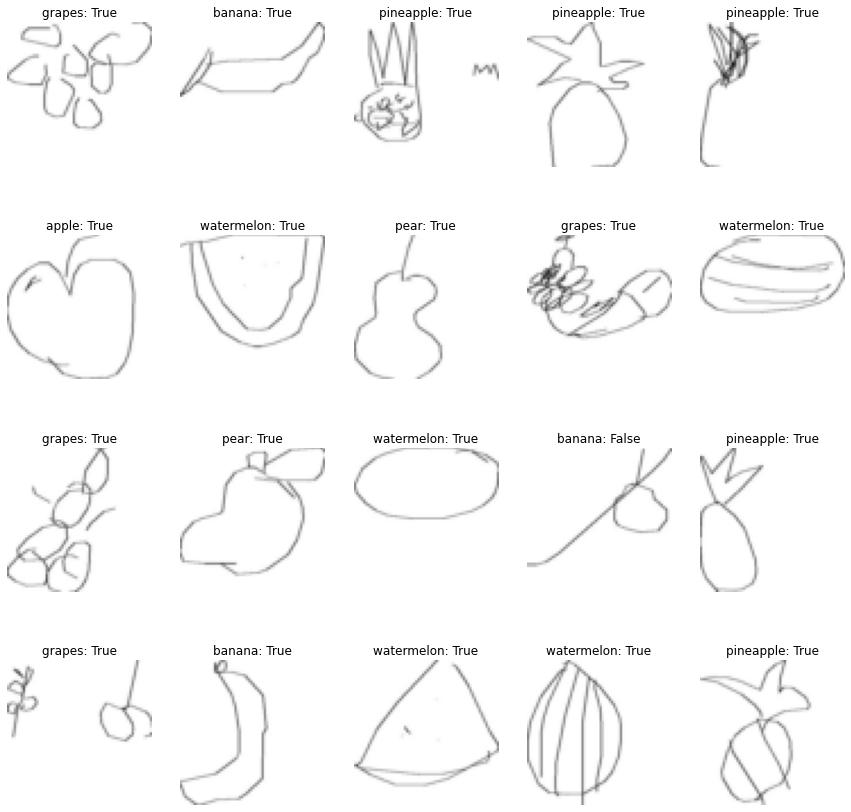

In [ ]:
classes = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  
to_pil = transforms.ToPILImage()
test_data = iter(test_loader).next()
images, labels = test_data["image"].cuda(),test_data["label"].cuda()
outputs = model(images)
_, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
predicted = predicted.squeeze()
labels = torch.argmax(labels.squeeze(),dim = 1)
  
fig, axs = plt.subplots(4, 5, figsize=(15,15))
for idx in range(len(images)):
  i = idx // 5
  j = idx % 5

  image = to_pil(images[idx])
 
  res = labels[idx] == predicted[idx]

  axs[i,j].imshow(image) #plot the data
  axs[i,j].axis('off')
  axs[i,j].set_title(classes[predicted[idx]] + ": " + str(res.item()))
plt.show()

# real image model 

In [ ]:
#@title 5.1 Real-world dataset preparing

QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  

train_realworld_dir = sys.path[0]+'/compressed_realworld_train.npz'
train_realworld = ImageDataset(train_realworld_dir, QURIES, image_size = 64, class_size = 4000,transform = True)
train_loader = DataLoader(train_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)

test_realworld_dir = sys.path[0]+'/compressed_realworld_test.npz'
test_realworld = ImageDataset(test_realworld_dir, QURIES, image_size = 64, class_size = 1000,transform = True)
test_loader_realworld = DataLoader(test_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)


In [ ]:
#@title 5.2 VGG16 Hyper-parameter setting
num_classes = 7
num_epochs = 5
batch_size = 128
learning_rate = 0.01 #0.03

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.007, momentum = 0.9)  
RESUME =True

In [ ]:
# record history data
if RESUME:
  checkpoint = torch.load(sys.path[0]+'/best_vgg16_model_realworld_10epoch_with_loss_lr_001.pth')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  train_realworld_acc = checkpoint['train_realworld_acc']
  train_realworld_loss = checkpoint["train_realworld_loss"]
  val_realworld_acc = checkpoint["val_realworld_acc"]
  val_realworld_loss= checkpoint["val_realworld_loss"]
  
else:
  start_epoch =0
  train_realworld_acc = []
  train_realworld_loss = []
  val_realworld_acc = []
  val_realworld_loss = []


In [ ]:
#@title 5.3 Real-world model training and validation
import gc
total_step = len(train_loader)

for epoch in range(start_epoch,start_epoch+num_epochs):
    for data in train_loader:  
        # Move tensors to the configured device
        images = data['image'].to(device)
        labels = data['label'].to(device)
        correct_t = 0
        total_t = 0
        # Forward pass
        model.train()
        outputs = model(images)
        loss = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
        _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
        total_t += labels.size(0)
        correct_t +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    
    
    train_realworld_loss.append(loss.item())
    train_realworld_acc.append(correct_t/total_t)
    print ('Epoch [{}/{}], Training Loss: {:.4f}' 
                   .format(epoch+1,start_epoch+num_epochs, loss.item()))
            
    # Validation
    
    with torch.no_grad():
        model.eval()
        correct_v = 0
        total_v = 0
        for data in test_loader_realworld:
            images = data['image'].to(device)
            labels = data['label'].to(device)
        

            outputs = model(images)
            loss_v = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
   
            _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
            total_v += labels.size(0)
            correct_v +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()
            
            del images, labels, outputs
        val_realworld_loss.append(loss_v.item())
        val_realworld_acc.append(correct_v/total_v)
        print(f"Validation accuracy: {(correct_v/total_v):.3f}")
       
print(f"train_acc:{(np.mean([v for v in train_realworld_acc])):.3f},val_acc:{(np.mean([v for v in val_realworld_acc])):.3f}")

Epoch [11/15], Training Loss: 0.2029
Validation accuracy: 0.806
Epoch [12/15], Training Loss: 0.1519
Validation accuracy: 0.850
Epoch [13/15], Training Loss: 0.2191
Validation accuracy: 0.850
Epoch [14/15], Training Loss: 0.2138
Validation accuracy: 0.746
Epoch [15/15], Training Loss: 0.2417
Validation accuracy: 0.859
train_acc:0.899,val_acc:0.825


In [ ]:
torch.save({
            'epoch': 10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_realworld_acc': train_realworld_acc,
            'train_realworld_loss': train_realworld_loss,
            'val_realworld_acc': val_realworld_acc,
            'val_realworld_loss': val_realworld_loss,
      
          
            }, sys.path[0]+'/best_vgg16_model_realworld_10epoch_with_loss_lr_001.pth')

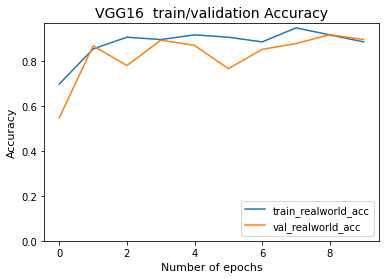

In [ ]:
#@title 5.4 Visulize model performance
import matplotlib.pyplot as plt
# Plot curve
x = [i for i in range(10)]
plt.plot(x, train_realworld_acc)
plt.plot(x, val_realworld_acc)

plt.legend(['train_realworld_acc', 'val_realworld_acc'], loc='lower right')
plt.title('VGG16  train/validation Accuracy',  fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.ylim(0)

plt.show()

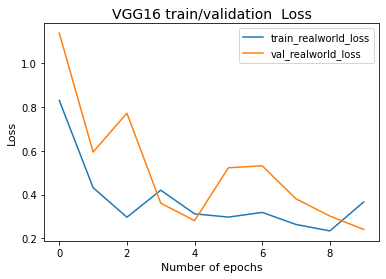

In [ ]:
# Plot curve
x = [i for i in range(10)]
plt.plot(x, train_realworld_loss)
plt.plot(x, val_realworld_loss)
plt.legend(['train_realworld_loss', 'val_realworld_loss'], loc='upper right')
plt.title('VGG16 train/validation  Loss',  fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Loss', fontsize=11)

plt.show()

# Image feature similarity

In [ ]:
#@title 6.1 Collect real_image and sketch image features
def get_feature(model,feature,test_loader):
  with torch.no_grad():
    for data in test_loader:
      images = data['image'].to(device)
      labels = data['label'].to(device)
      outputs = model(images)

      labels_sq = torch.argmax(labels.squeeze(),dim = 1).tolist()

      
      for i in range(outputs.shape[0]):
        feature[labels_sq[i]].append(outputs[i])
        
  fea_resize = torch.empty((7000,7))
  for i in range(len(feature)):
    fea_resize[i*1000:1000*(i+1)] = torch.stack(feature[i])
  return fea_resize

reshape features:
1. sketch feature: (1,7) * 7000 images
2. real feature: (7,1000)*7    --> matrix M(7000 * 7)

caculate cos similarity for each sketch image

In [ ]:
sketch_features = defaultdict(list)
features_real = defaultdict(list)

In [ ]:
from collections import defaultdict
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  

sketch_features = defaultdict(list)
features_real = defaultdict(list)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7
num_epochs = 15
batch_size = 128
learning_rate = 0.01  #0.03


model_sketch = VGG16(num_classes).to(device)

model_real =  VGG16(num_classes).to(device)

checkpoint1 = torch.load(sys.path[0]+'/vgg16_model_quickdraw_10epoch_with_loss_lr_001.pth')
model_sketch.load_state_dict(checkpoint1['model_state_dict'])


checkpoint2 = torch.load(sys.path[0]+'/best_vgg16_model_realworld_10epoch_with_loss_lr_001.pth')
model_real.load_state_dict(checkpoint2['model_state_dict'])



test_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_test.npz'
test_quickdraw = ImageDataset(test_quickdraw_dir, QURIES, image_size = 64, class_size = 1000,transform = True)
test_loader_sketch = DataLoader(test_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)



test_realworld_dir = sys.path[0]+'/compressed_realworld_test.npz'
test_realworld = ImageDataset(test_realworld_dir, QURIES, image_size = 64, class_size = 1000,transform = True)
test_loader_real = DataLoader(test_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)




In [ ]:
fea1 = get_feature(model_sketch,sketch_features,test_loader_sketch)
fea2 = get_feature(model_real,features_real,test_loader_real)

In [ ]:
#@title 6.2 Caculate cos similarity for each sketch image

def cos_similarity(k,fea2,fea1):
  correct = 0
  total = 0
  real_matrix = F.normalize(fea2) 
  for idx, image in enumerate(fea1):
    feature1 = image.reshape(1,-1)
    a = F.normalize(feature1)
    res = F.cosine_similarity(a,real_matrix)
    _,predict = res.topk(k, largest=True, sorted=True)

    correct += sum([idx//1000==i//1000 for i in predict]).item()
    total += k

  print(f"k = {k}, predict accuracy is {(correct/total):.3f}")  
  return (correct/total)


In [ ]:
topk_acc = []
for kk in [1,3,5,10,20]:
  acc = cos_similarity(kk,fea2,fea1)
  topk_acc.append(acc)

k = 1, predict accuracy is 0.134
k = 3, predict accuracy is 0.137
k = 5, predict accuracy is 0.135
k = 10, predict accuracy is 0.134
k = 20, predict accuracy is 0.133


# Archive data

create model data history

In [ ]:
import pickle
def save_model_history(metrics, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(metrics, file)

def load_model_history(filepath):
    with open(filepath, 'rb') as file:
        metrics = pickle.load(file)
    return metrics

# save_model_history(model_history, './resnet_data.pkl')

# model_history = load_model_history('./resnet_data.pkl')

In [ ]:
model_history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],

    # Please save the following metric
    "train_realworld_acc": [],
    "train_quickdraw_acc": [],
    "val_realworld_acc": [],
    "val_quickdraw_acc": [],
    "train_realworld_loss": [],
    "train_quickdraw_loss": [],
    "val_realworld_loss": [],
    "val_quickdraw_loss": [],
    "k_choice": [], # [1,3,5,10,20]
    "topk_acc": []
}

In [ ]:
# get best quickdraw model
checkpoint_quickdraw = torch.load(sys.path[0]+'/vgg16_model_quickdraw_10epoch_with_loss_lr_001.pth')

train_quickdraw_acc = checkpoint_quickdraw['train_quickdraw_acc']
train_quickdraw_loss = checkpoint_quickdraw["train_quickdraw_loss"]
val_quickdraw_acc = checkpoint_quickdraw["val_quickdraw_acc"]
val_quickdraw_loss= checkpoint_quickdraw["val_quickdraw_loss"]



In [ ]:
# get best realworld model
checkpoint_realworld = torch.load(sys.path[0]+'/best_vgg16_model_realworld_10epoch_with_loss_lr_001.pth')
train_realworld_acc = checkpoint_realworld['train_realworld_acc']
train_realworld_loss = checkpoint_realworld["train_realworld_loss"]
val_realworld_acc = checkpoint_realworld["val_realworld_acc"]
val_realworld_loss= checkpoint_realworld["val_realworld_loss"]


In [ ]:
model_history["k_choice"] = [1,3,5,10,20]
model_history["topk_acc"] = topk_acc
model_history["epoch"] = [i for i in range(10)]
model_history["train_quickdraw_loss"] = train_quickdraw_loss
model_history["train_quickdraw_acc"] = train_quickdraw_acc
model_history["val_quickdraw_acc"] = val_quickdraw_acc
model_history["val_quickdraw_loss"] = val_quickdraw_loss

model_history["train_realworld_loss"] = train_realworld_loss
model_history["train_realworld_acc"] = train_realworld_acc
model_history["val_realworld_acc"] = val_realworld_acc
model_history["val_realworld_loss"] = val_realworld_loss



how to retrive the model 

In [ ]:
filepath = "/content/drive/My Drive/Colab Notebooks/CS5242"
save_model_history(model_history, filepath+'/vgg16_data_10epoch.pkl')

In [ ]:
model_history_VGG = load_model_history(filepath+'/vgg16_data_10epoch.pkl')